# Learning a Bayesian Network Classifier

In this notebook, you will learn how to use BNs, specifically a type of BN specifically dessigned for classification (BNC) such as a Tree-augmented Naive Bayes (TAN).

Let's start by loading the basic libraries:

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import BayesianModel

## Learning from real world data

In this notebook, we will use a classical dataset from the UCI repository to learn a BNC. Specifically

In [2]:
#load data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True).frame

 We need to discretize the data! Remember that we have been dealing with **discrete distributions** all the time!

In [3]:
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

In [4]:
for i in np.arange(data.shape[1]-1):
    data.iloc[:,i] = discretize(data.iloc[:,i], 3)[0]

In [5]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

We need to use a PGM to make a prediction. We can understand a prediction as a probabilistic query:
$$p(c|\mathbf{x})$$
And, more specifically, if we are only interesting into the most probable class for the given example, that is:
$$\arg\!\max_c p(c|\mathbf{x})$$
Thus, we are going to use VE to answer the MAP query $\arg\!\max_c p(c|\mathbf{x})$:

In [6]:
from pgmpy.inference import VariableElimination

def predict(model, class_var, samples):
    columns = list(samples.columns)
    columns.remove(class_var)
    inference = VariableElimination(model)
    y_pred=[]
    for i in np.arange(samples.shape[0]):
        ev = {}
        for j, c in enumerate(columns):
            ev[c] = samples.values[i,j]
        y_pred.append(inference.map_query([class_var], evidence=ev,
                                          show_progress=False)[class_var])
    return np.array(y_pred)

Now, we have everything we need to use our TAN model as a classifier.

We will learn the TAN classifier as well as a Decision Tree (DT) classifier to compare with. We are going to use a 5-fold Cross Validation to test the performance of both models:

Building tree: 100%|██████████| 435/435.0 [00:00<00:00, 503.63it/s]


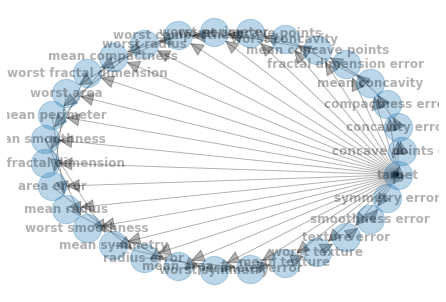

/Users/momo/anaconda3/envs/pgm/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:460: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
Building tree: 100%|██████████| 435/435.0 [00:00<00:00, 503.95it/s]


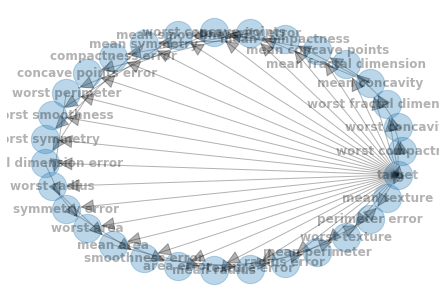

Building tree: 100%|██████████| 435/435.0 [00:00<00:00, 623.98it/s]


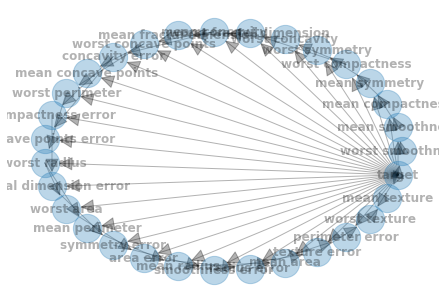

/Users/momo/anaconda3/envs/pgm/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:460: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
Building tree: 100%|██████████| 435/435.0 [00:00<00:00, 591.37it/s]


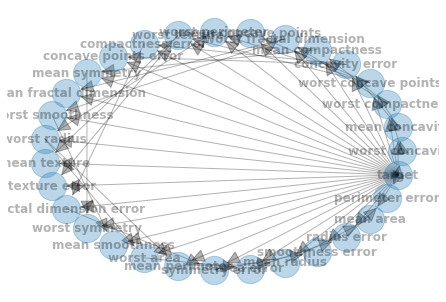

/Users/momo/anaconda3/envs/pgm/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:460: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
Building tree: 100%|██████████| 435/435.0 [00:00<00:00, 627.06it/s]


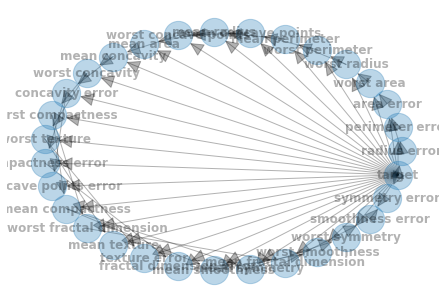

/Users/momo/anaconda3/envs/pgm/lib/python3.6/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:460: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()


Accuracy  DT: 0.952522900170781 +- 0.017279276824097117
Accuracy TAN: 0.9367179009470579 +- 0.02035287499544502


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import TreeSearch

desc_features=range(len(data.columns)-1)
class_feature=len(data.columns)-1
class_feature_name="target"
skf = StratifiedKFold(n_splits=5)

dt_accs=[]
tan_accs=[]
for train_index, test_index in skf.split(data.iloc[:,desc_features], data.iloc[:,class_feature]):
    Xy_train, Xy_test = data.iloc[train_index,:], data.iloc[test_index,:]
    X_train, X_test = data.iloc[train_index,desc_features], data.iloc[test_index,desc_features]
    y_train, y_test = data.iloc[train_index,class_feature], data.iloc[test_index,class_feature]
    
    dt_classifier = DecisionTreeClassifier(max_depth=4)
    dt_classifier.fit(X_train, y_train)
    dt_pred_y = dt_classifier.predict(X_test)
    dt_accs.append(np.sum(dt_pred_y==y_test)/float(len(y_test)))

    est = TreeSearch(Xy_train, root_node=data.columns[np.random.choice(desc_features)])
    tan_dag = est.estimate(estimator_type="tan", class_node=class_feature_name)
    nx.draw_circular(tan_dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
    plt.show()
    tan_classifier = BayesianModel(tan_dag.edges())
    tan_classifier.fit(data=Xy_train, estimator=MaximumLikelihoodEstimator)
    tan_pred_y = predict(tan_classifier, class_feature_name, Xy_test)
    
    tan_accs.append(np.sum(tan_pred_y==y_test)/float(len(y_test)))

print("Accuracy  DT:",np.mean(dt_accs),"+-",np.std(dt_accs))
print("Accuracy TAN:",np.mean(tan_accs),"+-",np.std(tan_accs))